<a href="https://colab.research.google.com/github/kibeer/CVnotebook/blob/main/interactive_notebook_stable_diffusion_Anima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion Interactive Notebook 📓 🤖

Name: Bei Jin

The paper link: [High-Resolution Image Synthesis with Latent Diffusion Models
](https://openaccess.thecvf.com/content/CVPR2022/papers/Rombach_High-Resolution_Image_Synthesis_With_Latent_Diffusion_Models_CVPR_2022_paper.pdf)

A widgets-based interactive notebook for Google Colab that lets users generate AI images from prompts (Text2Image) using [Stable Diffusion (by Stability AI, Runway & CompVis)](https://en.wikipedia.org/wiki/Stable_Diffusion).

This notebook aims to be an alternative to WebUIs while offering a simple and lightweight GUI for anyone to get started with Stable Diffusion (Anima). I added the anything_v4 model for anima image generation and the img2img part, also, the notebook is splitted to have a better understanding.

Uses Stable Diffusion, [HuggingFace](https://huggingface.co/) Diffusers and [Jupyter widgets](https://github.com/jupyter-widgets/ipywidgets).

<br/>

From [stable-diffusion-interactive-notebook](https://github.com/redromnon/stable-diffusion-interactive-notebook)

In [1]:
#@title 👇 Installing dependencies { display-mode: "form" }

!pip -q install torch diffusers transformers accelerate scipy safetensors xformers mediapy ipywidgets==7.7.1
#!pip install diffusers transformers accelerate torch

In [2]:
#@title 👇 Headers { form-width: "20%", display-mode: "form" }

from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionPipeline, EulerAncestralDiscreteScheduler, DDIMScheduler, EulerDiscreteScheduler, UniPCMultistepScheduler
from diffusers.models import AutoencoderKL
import torch
import ipywidgets as widgets
import importlib

#Enable third party widget support
from google.colab import output
from google.colab import files
output.enable_custom_widget_manager()

from PIL import Image
from io import BytesIO

from IPython.display import display, clear_output
import io

#Pipe
pipe = None

In [4]:
#@title 👇 Model list { form-width: "20%", display-mode: "form" }
select_model = widgets.Dropdown(
    options=[
        ("Stable Diffusion 2.1 Base" , "stabilityai/stable-diffusion-2-1-base"),
        ("Stable Diffusion 2.1" , "stabilityai/stable-diffusion-2-1"),
        ("Stable Diffusion 1.5", "runwayml/stable-diffusion-v1-5"),
        ("Dreamlike Photoreal 2.0" , "dreamlike-art/dreamlike-photoreal-2.0"),
        ("OpenJourney v4" , "prompthero/openjourney-v4"),
        ("Anything V4.0", "xyn-ai/anything-v4.0") #Anima pictures generation
    ],
    description="Select Model:"
)

In [5]:
#@title 👇 Schedular list { form-width: "20%", display-mode: "form" }
select_sampler = widgets.Dropdown(
    options=[
        "EulerAncestralDiscreteScheduler",
        "EulerDiscreteScheduler",
        "UniPCMultistepScheduler",
        "DDIMScheduler"
    ],
    description="Select Schedular:"
)
select_sampler.style.description_width = "auto"

In [6]:
#Safety Checker
safety_check = widgets.Checkbox(
    value=True,
    description="Enable Safety Check",
    layout=widgets.Layout(margin="0px 0px 0px -85px")
)

#Output
out = widgets.Output()

#Apply Settings
apply_btn = widgets.Button(
    description="Apply",
    button_style="info"
)

In [7]:
#Get scheduler
def get_scheduler(name):

  match name:

    case "EulerAncestralDiscreteScheduler":
      return EulerAncestralDiscreteScheduler.from_pretrained(select_model.value, subfolder="scheduler")

    case "DDIMScheduler":
      return DDIMScheduler.from_pretrained(select_model.value, subfolder="scheduler")

    case "EulerDiscreteScheduler":
      return EulerDiscreteScheduler.from_pretrained(select_model.value, subfolder="scheduler")

    case "UniPCMultistepScheduler":
      return UniPCMultistepScheduler.from_pretrained(select_model.value, subfolder="scheduler")

In [8]:
#@title 👇 Pipeline { form-width: "20%", display-mode: "form" }
def pipeline(p):

  global pipe

  out.clear_output()
  apply_btn.disabled = True

  with out:

    print("Running, please wait...")

    pipe = StableDiffusionPipeline.from_pretrained(
      select_model.value,
      scheduler=get_scheduler(select_sampler.value),
      torch_dtype=torch.float16,
      vae=AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")
    ).to("cuda")

    if not safety_check.value:
      pipe.safety_checker = None

    pipe.enable_xformers_memory_efficient_attention()

    print("Finished!")

  apply_btn.disabled = False

In [9]:
#@title 👇 Display GUI { form-width: "20%", display-mode: "form" }
apply_btn.on_click(pipeline)

widgets.VBox(
    [
      widgets.HTML(value="<h2>Configure Pipeline</h2>"),
      select_model, select_sampler, safety_check, apply_btn, out
    ]
)

In [10]:
#@title 👇 Generating parameters { form-width: "20%", display-mode: "form" }

import ipywidgets as widgets, mediapy, random
import IPython.display


#PARAMETER WIDGETS
width = "300px"

prompt = widgets.Textarea(
    value="",
    placeholder="Prompt: what you want",
    #description="Prompt:",
    rows=5,
    layout=widgets.Layout(width="600px")
)

neg_prompt = widgets.Textarea(
    value="",
    placeholder="Negative prompt: what you hate",
    #description="Negative Prompt:",
    rows=5,
    layout=widgets.Layout(width="600px")
)

num_images = widgets.IntText(
    value=1,
    description="Images:",
    layout=widgets.Layout(width=width),
)

steps = widgets.IntText(
    value=30,
    description="Steps:",
    layout=widgets.Layout(width=width)
)

CFG = widgets.FloatText(
    value=7.5,
    description="CFG:",
    layout=widgets.Layout(width=width)
)

img_height = widgets.Dropdown(
    options=[('512px', 512), ('1024px', 1024)],
    value=512,
    description="Height:",
    layout=widgets.Layout(width=width)
)

img_width = widgets.Dropdown(
    options=[('512px', 512), ('1024px', 1024)],
    value=512,
    description="Width:",
    layout=widgets.Layout(width=width)
)

random_seed = widgets.IntText(
    value=-1,
    description="Seed:",
    layout=widgets.Layout(width=width),
    disabled=False
)

generate = widgets.Button(
    description="Generate",
    disabled=False,
    button_style="primary"
)

display_imgs = widgets.Output()


In [13]:
#@title 👇 Generating images { form-width: "20%", display-mode: "form" }
def generate_img(i):

  #Clear output
  display_imgs.clear_output()
  generate.disabled = True

  #Calculate seed
  seed = random.randint(0, 2147483647) if random_seed.value == -1 else random_seed.value

  with display_imgs:

    print("Running...")

    images = pipe(
      prompt.value,
      height = img_height.value,
      width = img_width.value,
      num_inference_steps = steps.value,
      guidance_scale = CFG.value,
      num_images_per_prompt = num_images.value,
      negative_prompt = neg_prompt.value,
      generator = torch.Generator("cuda").manual_seed(seed),
    ).images

    mediapy.show_images(images)

    print(f"Seed:\n{seed}")

  generate.disabled = False

In [14]:
#@title 👇 Display GUI { form-width: "20%", display-mode: "form" }
generate.on_click(generate_img)

widgets.VBox(
    [
      widgets.AppLayout(
        header=widgets.HTML(
            value="<h2>Stable Diffusion</h2>",
        ),
        left_sidebar=widgets.VBox(
            [num_images, steps, CFG, img_height, img_width, random_seed]
        ),
        center=widgets.VBox(
            [prompt, neg_prompt, generate]
        ),
        right_sidebar=None,
        footer=None
      ),
      display_imgs
    ]
)

**You can use the prompt:**

masterpiece, best quality, 1girl, white hair, medium hair, cat ears, closed eyes, looking at viewer, :3, cute, scarf, jacket, outdoors, streets

to generate the example anima people.

# **Image to Image transfer 😀**
After the text to image, I provide a new function to generate similar anima image by providing image. It uses the StableDiffusionImg2ImgPipeline and the anything-v4.0 model from huggingface. You can upload an image what you want (it is perfect if you choose an *Anima one*). The output will be saved as "result.png". Enjoy it!

Examples are shown below:

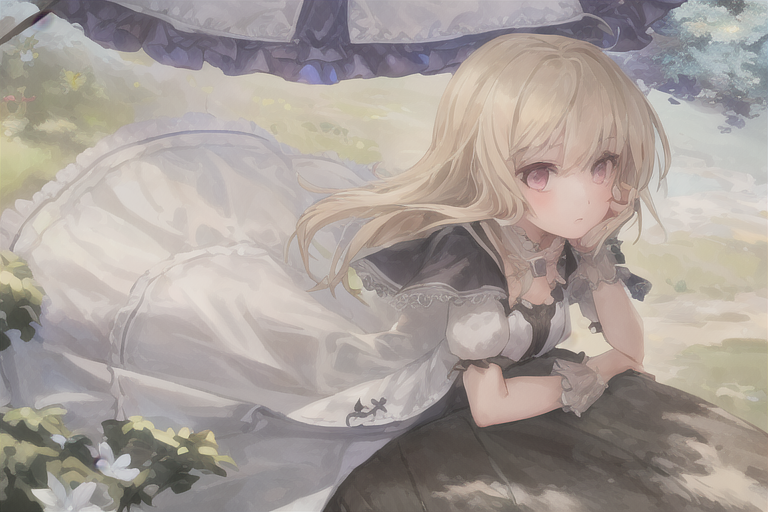

In [17]:
#Example 1:
from IPython.display import Image, display
example1_path = '/content/ex1.png'

display(Image(filename=example1_path))

In [18]:
#Example 2:
example2_path = '/content/ex2.png'

display(Image(filename=example2_path))

In [3]:
uploaded = files.upload()

image = None
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')
    content = uploaded[filename]
    image = Image.open(io.BytesIO(content))

if image is None:
    print("No image uploaded.")
else:
    original_width, original_height = image.size
    print(f"Original image size: {original_width} x {original_height}")

    # default size
    def get_default_output_size(width, height, max_size=1000):
        # factor
        if max(width, height) > max_size:
            scaling_factor = max_size / max(width, height)
        else:
            scaling_factor = 1.0
        output_width = int(width * scaling_factor)
        output_height = int(height * scaling_factor)
        return output_width, output_height

    default_output_width, default_output_height = get_default_output_size(original_width, original_height, max_size=1000)
    print(f"Default output size: {default_output_width} x {default_output_height}")

    # size of img
    max_size_slider = widgets.IntSlider(
        value=max(default_output_width, default_output_height),
        min=256,
        max=1000,
        step=1,
        description='Max Size:',
        continuous_update=True
    )

    # GUI
    display(max_size_slider)

    # load Stable Diffusion Img2Img Pipeline
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained("xyn-ai/anything-v4.0").to("cuda")

    # preprocess
    def preprocess_image(image, max_size):
        width, height = image.size
        # output size
        scaling_factor = min(max_size / width, max_size / height)
        new_width = int(width * scaling_factor)
        new_height = int(height * scaling_factor)
        image = image.convert("RGB")
        return image.resize((new_width, new_height), resample=Image.LANCZOS)

    # img2img
    def generate_img2img(prompt, init_image, strength=0.75, guidance_scale=7.5):
        images = pipe(prompt=prompt, image=init_image, strength=strength, guidance_scale=guidance_scale).images
        return images[0]

    # prompt
    prompt_text = widgets.Text(
        value='An anime character',
        description='Prompt:',
        disabled=False
    )

    # button to generate img
    generate_button = widgets.Button(description="Generate")

    # show img
    output = widgets.Output()

    # click function
    def on_generate_clicked(b):
        with output:
            clear_output()
            max_size = max_size_slider.value
            init_image = preprocess_image(image, max_size)
            display(init_image)  # original img

            if isinstance(init_image, Image.Image):
                generated_image = generate_img2img(prompt_text.value, init_image)
                generated_image.save("result.png")
                display(generated_image)  # generated img
            else:
                print("Error: The uploaded file is not a valid image.")

    generate_button.on_click(on_generate_clicked)

    # show GUI
    display(prompt_text, generate_button, output)

Saving 111826508_p1_master1200.jpg to 111826508_p1_master1200 (4).jpg
Uploaded file: 111826508_p1_master1200 (4).jpg
Original image size: 1200 x 1200
Default output size: 1000 x 1000


IntSlider(value=1000, description='Max Size:', max=1000, min=256)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Text(value='An anime character', description='Prompt:')

Button(description='Generate', style=ButtonStyle())

Output()